In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
#导入mindspore框架
import mindspore as ms
#导入mindspore中Neural Networks(nn)模块，包含预先定义的构建块或计算单元来构建神经网络。
from mindspore import nn
#导入mindspore中context模块，用于配置当前执行环境，包括执行模式等特性。
from mindspore import context
#导入参数初始化模块
from mindspore.common.initializer import Normal
from IPython.display import clear_output
%matplotlib inline

# 设置MindSpore的执行模式和设备，需要更改为CPU
context.set_context(mode=context.GRAPH_MODE, device_target='CPU')

In [9]:
N_SAMPLES = 40 #样本数
BATCH_SIZE = 40  #批量大小
NOISE_RATE = 0.2  #噪声率
INPUT_DIM = 1  #输入维度
HIDDEN_DIM = 100  #隐藏层维度
OUTPUT_DIM = 1   #输出维度
N_LAYERS = 6 #隐藏层数目
ITERATION = 1500   #最大输入迭代
LEARNING_RATE = 0.003  #学习率
DROPOUT_RATE = 0.7
WEIGHT_DECAY = 1e-4  #L2正则化惩罚数值
MAX_COUNT = 20  #最早终止参数
ACTIVATION = nn.LeakyReLU #激活函数

#固定结果
def fix_seed(seed=1):
    # reproducible
    random.seed(seed)
    np.random.seed(seed)

# 小批量样本索引
def sample_idx(m, n):
    A = np.random.permutation(m)
    idx = A[:n]
    return idx

In [10]:
#建立数据集x值，y值
fix_seed(5)
data_x = np.linspace(-1, 1, num=int(N_SAMPLES*2.5))[:, np.newaxis]
data_y = np.cos(np.pi*data_x)
p = np.random.permutation(len(data_x))
#建立训练集，测试集，验证集
train_x, train_y = data_x[p[0:N_SAMPLES]], data_y[p[0:N_SAMPLES]]
test_x, test_y = data_x[p[N_SAMPLES:N_SAMPLES*2]], data_y[p[N_SAMPLES:N_SAMPLES*2]]
validate_x, validate_y = data_x[p[N_SAMPLES*2:]], data_y[p[N_SAMPLES*2:]]
#设置y值噪声
noise = np.random.normal(0, NOISE_RATE, train_y.shape)
train_y += noise

In [16]:
#自定义Cosine网络
class CosineNet(nn.Cell):
    def __init__(self, batchnorm, dropout):
        super(CosineNet, self).__init__()
        layers = []
        if batchnorm:
            layers.append(nn.BatchNorm2d(INPUT_DIM))
        
        # 初始化隐含层
        for l_n in range(N_LAYERS):
            in_channels = HIDDEN_DIM if l_n > 0 else INPUT_DIM
            # 这里使用1x1Conv代替全连接算子，可以与BatchNorm2d算子配合的更好
            conv = nn.Conv2d(in_channels, HIDDEN_DIM, kernel_size=1, pad_mode='valid', has_bias=True, weight_init=Normal(0.01))
            layers.append(conv)
            if batchnorm:
                layers.append(nn.BatchNorm2d(HIDDEN_DIM))
            if dropout:
                layers.append(nn.Dropout(DROPOUT_RATE))
            layers.append(ACTIVATION())
        self.layers = nn.SequentialCell(layers)
        
        # 初始化输出层
        self.flatten = nn.Flatten() # 将(N,C,H,W)4维数据转为(N,C*H*W)2维
        self.fc = nn.Dense(HIDDEN_DIM, OUTPUT_DIM, weight_init=Normal(0.1), bias_init='zeros')
        
    def construct(self, x):
        # 构建隐含层
        x = self.layers(x)
        # 构建输出层
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [17]:
def build_fn(batchnorm, dropout, l2):
    # 实例化网络、Loss、optimizer
    net = CosineNet(batchnorm=batchnorm, dropout=dropout)
    loss = nn.loss.MSELoss()
    opt = nn.optim.Adam(net.trainable_params(), learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY if l2 else 0.0)
    # 构建计算loss和训练用的模块
    with_loss = nn.WithLossCell(net, loss)
    train_step = nn.TrainOneStepCell(with_loss, opt).set_train()
    return train_step, with_loss, net

# 针对5种不同设置，创建不同的训练任务
fc_train, fc_loss, fc_predict = build_fn(batchnorm=False, dropout=False, l2=False) # 默认任务
dropout_train, dropout_loss, dropout_predict = build_fn(batchnorm=False, dropout=True, l2=False) # 实验dropout功能
bn_train, bn_loss, bn_predict = build_fn(batchnorm=True, dropout=False, l2=False) # 实验batchnorm功能
l2_train, l2_loss, l2_predict = build_fn(batchnorm=False, dropout=False, l2=True) # 实验l2 regularization功能
early_stop_train, early_stop_loss, early_stop_predict = build_fn(batchnorm=False, dropout=False, l2=False) # 实验Early Stop功能

# 辅助函数，用于设置网络是否为train状态，用于batchnorm，dropout等算子判断是否处于train状态。
nets_train = [fc_train, dropout_train, bn_train, l2_train, early_stop_train]
nets_loss = [fc_loss, dropout_loss, bn_loss, l2_loss, early_stop_loss]
nets_predict = [fc_predict, dropout_predict, bn_predict, l2_predict, early_stop_predict]

def set_train(nets, mode=True):
    for net in nets:
        net.set_train(mode=mode)

In [18]:
# 将喂给网络的数据由(N,C)2维转为将(N,C,H,W)4维
data_xt, data_yt = ms.Tensor(data_x.reshape(data_x.shape + (1, 1)), ms.float32), ms.Tensor(data_y, ms.float32)
test_xt, test_yt = ms.Tensor(test_x.reshape(test_x.shape + (1, 1)), ms.float32), ms.Tensor(test_y, ms.float32)
validate_xt, validate_yt = ms.Tensor(validate_x.reshape(validate_x.shape + (1, 1)), ms.float32), ms.Tensor(validate_y, ms.float32)

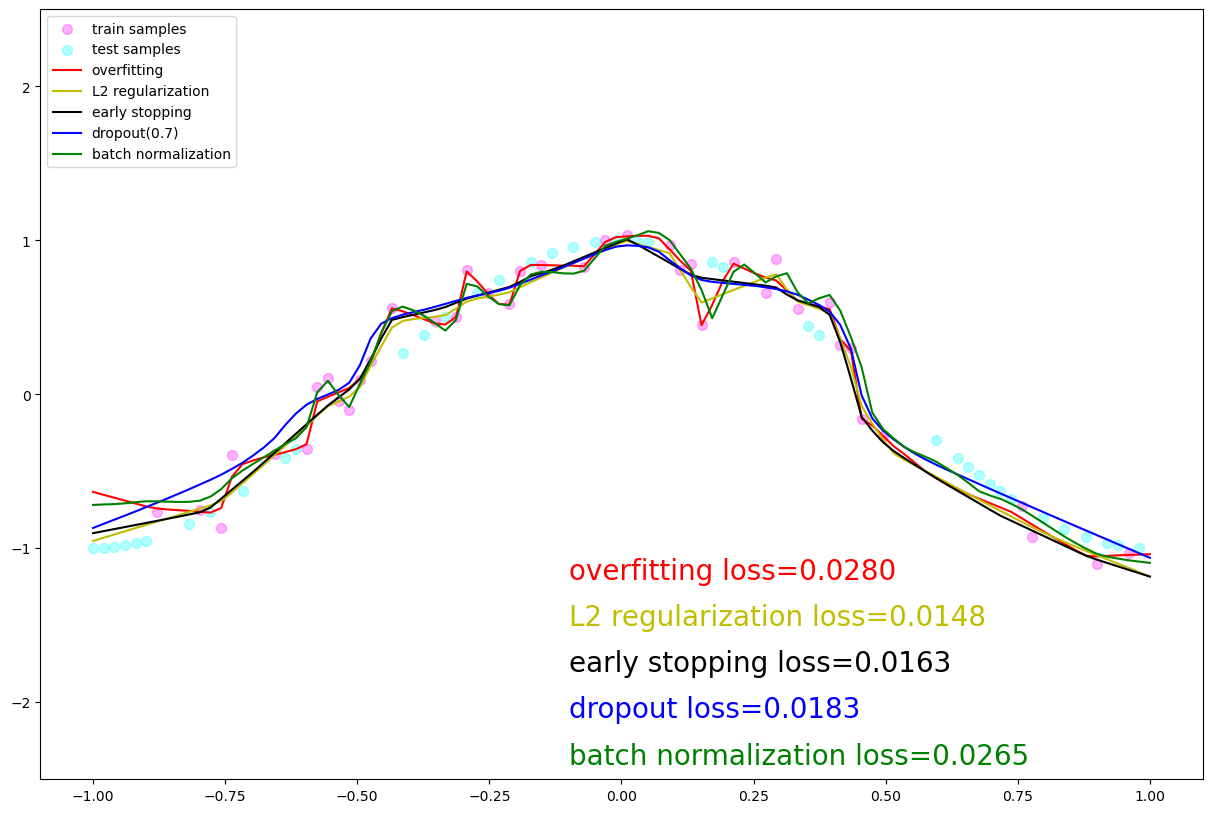

In [19]:
# 设置提前终止(Early Stop)用到的一些指标
early_stop = False # 为True时，终止相关的训练
min_val_loss = 1 # 足够大的初始值，训练过程中用于记录最小的验证loss
count = 0 # 训练迭代过程中，验证loss连续多少次大于min_val_loss

for it in range(ITERATION):
    # 每个迭代随机从训练集中选择一个batch的样本，当batch_size==N_SAMPLES时，仅作了shuffle
    mb_idx = sample_idx(N_SAMPLES, BATCH_SIZE)
    x_batch, y_batch = train_x[mb_idx, :], train_y[mb_idx, :]
    x_batch, y_batch = ms.Tensor(x_batch.reshape(x_batch.shape + (1, 1)), ms.float32), ms.Tensor(y_batch, ms.float32)
    
    set_train(nets_train, True) # 将网络设置为train状态
    fc_train(x_batch, y_batch)
    dropout_train(x_batch, y_batch)
    bn_train(x_batch, y_batch)
    l2_train(x_batch, y_batch)
    # 为True时，终止相关的训练
    if not early_stop:
        early_stop_train(x_batch, y_batch)
    
    if it % 20 == 0:
        set_train(nets_loss+nets_predict, False) # 将网络设置为非train状态
        # 计算各模型在测试集上的loss
        loss_fc = fc_loss(test_xt, test_yt)
        loss_dropout = dropout_loss(test_xt, test_yt)
        loss_bn = bn_loss(test_xt, test_yt)
        loss_l2 = l2_loss(test_xt, test_yt)
        loss_early_stop = early_stop_loss(test_xt, test_yt)
        
        # 计算各模型在全量样本上的预测值，用于评估模型的拟合效果
        all_fc = fc_predict(data_xt)
#         all_fc = fc_predict.predict(data_xt)
        all_dropout = dropout_predict(data_xt)
        all_bn = bn_predict(data_xt)
        all_l2 = l2_predict(data_xt)
        all_early_stop = early_stop_predict(data_xt)
        
        # 对于Early Stop任务，当验证集loss连续MAX_COUNT次大于min_val_loss时，终止该任务的训练
        if not early_stop:
            val_loss = early_stop_loss(validate_xt, validate_yt)
            if val_loss > min_val_loss:
                count += 1
            else:
                min_val_loss = val_loss
                count = 0
            
            if count == MAX_COUNT:
                early_stop = True
                print('='*10, 'early stopped', '='*10)
        
        # 画图
        plt.figure(1, figsize=(15,10))
        plt.cla()
        plt.scatter(train_x, train_y, c='magenta', s=50, alpha=0.3, label='train samples')
        plt.scatter(test_x, test_y, c='cyan', s=50, alpha=0.3, label='test samples')
        plt.plot(data_x, all_fc.asnumpy(), 'r', label='overfitting')
        plt.plot(data_x, all_l2.asnumpy(), 'y', label='L2 regularization')
        plt.plot(data_x, all_early_stop.asnumpy(), 'k', label='early stopping')
        plt.plot(data_x, all_dropout.asnumpy(), 'b', label='dropout({})'.format(DROPOUT_RATE))
        plt.plot(data_x, all_bn.asnumpy(), 'g', label='batch normalization')
        plt.text(-0.1, -1.2, 'overfitting loss=%.4f' % loss_fc.asnumpy(), fontdict={'size': 20, 'color': 'red'})
        plt.text(-0.1, -1.5, 'L2 regularization loss=%.4f' % loss_l2.asnumpy(), fontdict={'size': 20, 'color': 'y'})
        plt.text(-0.1, -1.8, 'early stopping loss=%.4f' % loss_early_stop.asnumpy(), fontdict={'size': 20, 'color': 'black'})
        plt.text(-0.1, -2.1, 'dropout loss=%.4f' % loss_dropout.asnumpy(), fontdict={'size': 20, 'color': 'blue'})
        plt.text(-0.1, -2.4, 'batch normalization loss=%.4f' % loss_bn.asnumpy(), fontdict={'size': 20, 'color': 'green'})

        plt.legend(loc='upper left');
        plt.ylim((-2.5, 2.5));
        clear_output(wait=True)
        plt.show()